# 3D patch-based segmentation with U-Net

Code started from [Francesco's tutorials](https://github.com/FrancescoLR/tutorials)



## Imports

In [229]:
import glob
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile
import matplotlib.pyplot as plt


import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, decollate_batch, DataLoader, CacheDataset, Dataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU, compute_meaniou
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ResizeWithPadOrCropd,
    RandCropByPosNegLabeld,
    Lambdad,
    ScaleIntensityd,
)
from monai.utils import first

import ignite
import torch, torchvision

print_config()

MONAI version: 0.9.1rc3
Numpy version: 1.22.4
Pytorch version: 1.12.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7a5de8b7b9db101a431e70ae2aa8ea7ebb8dfffe
MONAI __file__: /home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.1+cu116
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup 


### Paths and cuda check

In [230]:
main_dir = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/'
data_dir = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/'

[print(f"Data directory is: {data_dir}") if os.path.isdir(data_dir) else print("Check your data directory")]
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(torch.cuda.is_available())

Data directory is: /mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/
True


### Set images and segmentation paths

In [231]:
train_images_1 = []
train_labels_1 = []
test_images = []
test_labels = []

# List of subjects taken for the template construction
best_subjects_cc = ['sub-02','sub-03','sub-08','sub-09','sub-20','sub-29','sub-30','sub-33','sub-34'] # 9

# List of remaining subjects
all_subjects = list()
for i in range(35):
    all_subjects.append('sub-'+str(i+1).zfill(2))
rest_subjects = [elem for elem in all_subjects if elem not in best_subjects_cc]

# Train (rest subjects)
for i in range(len(rest_subjects)):
    input_t1 = data_dir + 'a123/' + rest_subjects[i] + '/input/' + rest_subjects[i] + '_T1.nii.gz'
    input_labels = data_dir + 'a123/' + rest_subjects[i] + '/input/' + rest_subjects[i] + '_labels.nii.gz'
    train_images_1.append(input_t1)
    train_labels_1.append(input_labels)
# Train dictionary
data_train_dicts_1 = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images_1, train_labels_1)
]   

# Test (best subjects)
for i in range(len(best_subjects_cc)):
    input_t1 = data_dir + 'a123/' + best_subjects_cc[i] + '/input/' + best_subjects_cc[i] + '_T1.nii.gz'
    input_labels = data_dir + 'a123/' + best_subjects_cc[i] + '/input/' + best_subjects_cc[i] + '_labels.nii.gz'
    test_images.append(input_t1)
    test_labels.append(input_labels)
# Test dictionary
data_test_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(test_images, test_labels)
]

num_train_samples = len(data_train_dicts_1)
num_test_samples = len(data_test_dicts)
num_total_samples = num_train_samples + num_test_samples
print(f"Train dataset is composed by {len(data_train_dicts_1)} ({num_train_samples/num_total_samples*100:.2f}%) subjects and validation by {len(data_test_dicts)} ({num_test_samples/num_total_samples*100:.2f}%).")

Train dataset is composed by 26 (74.29%) subjects and validation by 9 (25.71%).


### Set transforms and dataset

In [232]:
# Function to crop the eye from the medical image
def masked(data_dict):
    eye_mask = (data_dict["label"] != 0)
    eye_mask[eye_mask == True] = 1
    eye_mask[eye_mask == False] = 0
    data_dict["image"] = data_dict["image"] * eye_mask

    return data_dict
    
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), #Load image file or files from provided path based on reader.
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        ScaleIntensityd(keys=["image"], ), #Scale the intensity of input image to the given value range (minv, maxv). If minv and maxv and factor not provided, Normalize the data
        EnsureChannelFirstd(keys=["image", "label"]), #Automatically adjust or add the channel dimension of input data to ensure channel_first shape.
        Orientationd(keys=["image", "label"], axcodes="RAS"), #Change the input image’s orientation into the specified based on axcodes.
        Spacingd(keys=["image", "label"], pixdim=(
            1, 1, 1), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(160, 160, 160)),
        masked,
        # RandCropByPosNegLabeld( #Crop random fixed sized regions with the center being a foreground or background voxel based on the Pos Neg Ratio. I recommend to use it since improves dice and IoU score
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(96, 96, 96),
        #     pos=1,
        #     neg=1,
        #     num_samples=4,
        #     image_key="image",
        #     image_threshold=0,
        # ),
    ]    
)

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        ScaleIntensityd(keys=["image"],),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAI"),
        # Spacingd(keys=["image", "label"], pixdim=(
        #     1, 1, 1), mode=("bilinear", "nearest")),
        # ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(176, 256, 176)),
        masked,
        # RandCropByPosNegLabeld( #Crop random fixed sized regions with the center being a foreground or background voxel based on the Pos Neg Ratio. 
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(96, 96, 96),
        #     pos=1,
        #     neg=1,
        #     num_samples=4,
        #     image_key="image",
        #     image_threshold=0,
        # ),
    ]
)

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to try the regular Dataset, just change to use the commented code below.

In [233]:
train_ds = CacheDataset(
    data=data_train_dicts_1, transform=train_transforms,
    cache_rate=1.0, num_workers=8)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=8)

test_ds = CacheDataset(
    data=data_test_dicts, transform=test_transforms, cache_rate=1.0, num_workers=8)
# val_ds = Dataset(data=val_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8)

Loading dataset: 100%|██████████| 9/9 [00:00<00:00, 13.71it/s]


In [234]:
# '''
import SimpleITK as sitk

# Saving test_loader images
i = 0
for _, dict in enumerate(test_loader):
    print(f"dict: {dict['image'].shape}")
    im_tensors = dict['image']
    # lab_tensors = dict['label'][0][0]
    print(im_tensors[0].detach().cpu().numpy().shape)
    im_trans = sitk.GetImageFromArray(np.transpose(im_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    # lab_trans = sitk.GetImageFromArray(torch.argmax(lab_tensors, dim=1).detach().cpu()[0,:,:,:].numpy())
    sitk.WriteImage(im_trans, main_dir+'im_trans_masked'+str(i)+'.nii.gz')
    i += 1
    if i == 1:
        break
# '''

dict: (1, 1, 176, 256, 176)
(1, 176, 256, 176)


#### Check transforms in DataLoader

image shape: (176, 256, 176), label shape: (176, 256, 176)


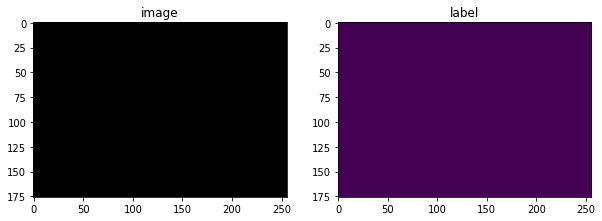

In [237]:
data_iter = iter(test_loader)
random_data = data_iter.next()
image, label = (random_data["image"][0][0], random_data["label"][0][0]) # [0][0] is to show only the image shape
print(f"image shape: {image.shape}, label shape: {label.shape}")

# plot the slice [:, :, 80]
plt.figure("check", (10,5))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()
#print(len(torch.unique(label)))


### Create Model, Loss, Optimizer

In [238]:
# Create UNet, DiceLoss and Adam optimizer
# import gc 
# gc.collect()
# torch.cuda.empty_cache()
device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 10,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    dropout = 0.5
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")

### Inference

Total DSC is 0.5930375456809998. 
Total IoU score is 0.4942435026168823.
Dice per class: [0.6186713576316833, 0.6833220720291138, 0.718679666519165, 0.5941488742828369, 0.693603515625, 0.6383098363876343, 0.6851651668548584, 0.6821538805961609]. 
IoU per class: [0.4926207959651947, 0.5793008208274841, 0.6224082112312317, 0.46919167041778564, 0.5857326984405518, 0.5140339136123657, 0.5782992839813232, 0.5726327300071716]


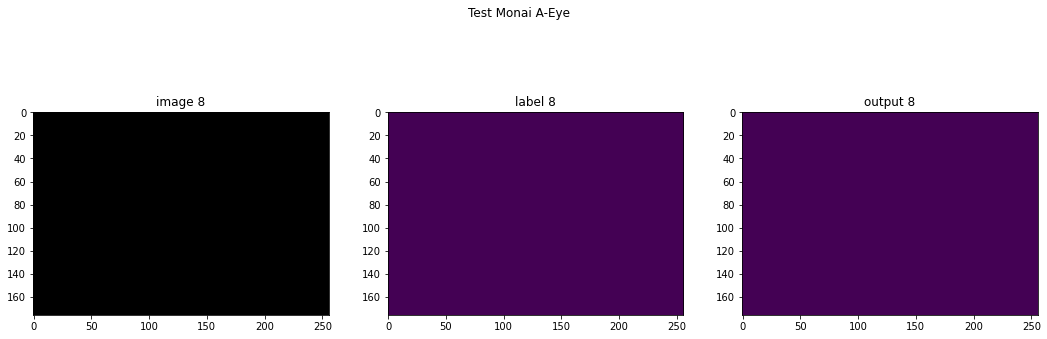

: 

: 

In [239]:
import SimpleITK as sitk

FILE = "3dmultilabel_v1.pth"

device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 10,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    dropout = 0.5
).to(device)

model.load_state_dict(torch.load(
    os.path.join(main_dir, FILE)))

# IoU metric
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=10)])
post_label = Compose([AsDiscrete(to_onehot=10)])
iou_metric = MeanIoU(include_background=False, reduction="mean")
metric_iou_values = []

model.eval()

with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        test_inputs, test_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (176, 256, 176)
        sw_batch_size = 4

        val_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model
        )

        test_outputs = [post_pred(j) for j in decollate_batch(val_outputs)]
        test_labels = [post_label(j) for j in decollate_batch(test_labels)]
        iou_metric(y_pred=test_outputs, y=test_labels)
        dice_metric(y_pred=test_outputs, y=test_labels)

        # plot the slice [:, :, 80]
        fig = plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 70], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 70])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 70])
        # print(val_outputs.shape)
        im_result = sitk.GetImageFromArray(np.transpose(torch.argmax(val_outputs, dim=1).detach().cpu().numpy(), (3,2,1,0)))
        if i == 0:
            sitk.WriteImage(im_result, main_dir+'result_'+str(i)+'.nii.gz')
        fig.suptitle('Test Monai A-Eye')
        # plt.show()
    
    # aggregate the final mean dice and IoU results
    dice_array = dice_metric.get_buffer()
    test_metric_dice = dice_metric.aggregate().item()
    iou_array = iou_metric.get_buffer() #(9, 10) --> 25 subjects and 10 classes
    test_metric_iou = iou_metric.aggregate().item()
    print(f"Total DSC is {test_metric_dice}. \nTotal IoU score is {test_metric_iou}.")
    
    # DSC per class
    dice_array_n = dice_array[:,:-1].transpose(0, 1) # to get in each line the IoU of each class (and eliminate NaN values of backgrounf)--> (6, 25)
    dice_array_mean = []
    for i, val in enumerate(dice_array_n):
        dice_array_mean.append(torch.mean(dice_array_n[:, i]).item())

    # IoU per class
    iou_array_n = iou_array[:,:-1].transpose(0, 1) # to get in each line the IoU of each class (and eliminate NaN values of backgrounf)--> (6, 25)
    iou_array_mean = []
    for i, val in enumerate(iou_array_n):
        iou_array_mean.append(torch.mean(iou_array_n[:, i]).item())

    print(f"Dice per class: {dice_array_mean}. \nIoU per class: {iou_array_mean}")